# Analysis with simulated data

- data in the "caclean-masterdir” onedrive folder:
    - 4D TIFFs (the name starts with confocalSNR…,)
    - can be opened straight with Fiji/ImageJ (setting B & C to scale from 1.0 to 1.8 and choosing the jet lookup table)
    - contain FCa normalised as F/F_0
    - time steps are 1ms 
    - x,y,z voxel size is 0.215 um or very similar

- **REMARK**: not part yet of project --> do not upload in github at the end

In [ ]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [1]:
import numpy as np
import napari
import os
from scipy.ndimage import gaussian_filter, grey_dilation
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, grey_dilation
from skimage.filters import threshold_otsu

# import tifffile
# from scipy import signal
# from scipy.io import loadmat

#### Load data

Load noisy data

---> don't need this for the moment

In [3]:
# data_path = r'C:\Users\dotti\OneDrive - Universitaet Bern\caclean-masterdir'
# filename_snr100 = 'confocalSNR100.tiff'
# filemane_snr20 = 'confocalSNR20.tiff'


# # load tiff volume
# data_snr100 = tifffile.imread(os.path.join(data_path, filename_snr100)) # 151(t) x 22(z) x 80(y) x 54(x)
# data_snr20 = tifffile.imread(os.path.join(data_path, filemane_snr20)) # 151(t) x 22(z) x 80(y) x 54(x)
# # need to pad data

In [4]:
# data_snr100.shape, data_snr20.shape

In [5]:
# fig_t = 80
# fig_z = 11

# # plot sample frame from data_snr100 and data_snr20
# plt.figure(figsize=(6,6))
# plt.subplot(1,2,1)
# plt.imshow(data_snr100[fig_t,fig_z,:,:])
# plt.title('SNR 100')
# plt.subplot(1,2,2)
# plt.imshow(data_snr20[fig_t,fig_z,:,:])
# plt.title('SNR 20')
# plt.show()

In [6]:
# # open snr_100 using napari
# viewer = napari.view_image(data_snr100)

Load clean data

---> need to find/generate corresponding noisy data

In [7]:
clean_data_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\caclean-masterdir\CardiacCalcium_TestCaCLEAN\simulatedMicroscopy_outputs"
filename_clean = "FCa_1umSpacing_NoMito_interp53_151timesteps.npz"
data_clean = np.load(os.path.join(clean_data_path, filename_clean))

In [8]:
data_clean.files

['nn_interp']

In [9]:
data_clean = data_clean["nn_interp"]  # 151(t) x 213(z) x 205(y) x 317(x)

In [10]:
data_clean.shape

(151, 213, 205, 317)

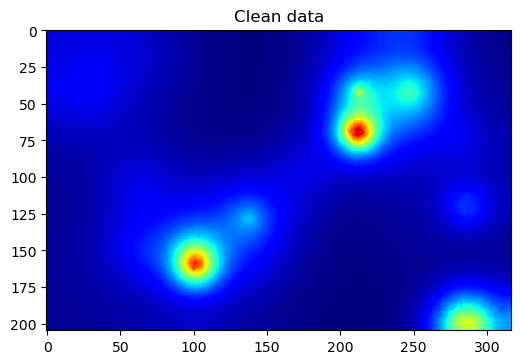

In [11]:
fig_t = 75
fig_z = 106

# plot sample frame from data_clean
plt.figure(figsize=(6, 6))
plt.imshow(data_clean[fig_t, fig_z, :, :], cmap="jet")
plt.title("Clean data")
plt.show()

In [12]:
data_clean[fig_t, fig_z, :, :].shape, data_clean[fig_t, fig_z, :, :].squeeze().shape

((205, 317), (205, 317))

In [13]:
# visualize clean data with Napari
viewer = napari.view_image(data_clean)

Load Matlab files

---> don't need this for the moment

In [14]:
# matlab_data_path = r'C:\Users\dotti\OneDrive - Universitaet Bern\caclean-masterdir\CardiacCalcium_TestCaCLEAN\simulatedMicroscopy_outputs'
# # load matlab file
# mat = loadmat(os.path.join(matlab_data_path,
#                           'simulatedMicroscopyResults_interp53_SNR20_1umSpacing_NoMito_54x80x151.mat'))
# #this is the same data as data_snr20 !!!

In [15]:
# mat.keys()

In [16]:
# data_denoised = mat['MultiIdenoised']
# data_bgr = mat['MultiBgr']

In [17]:
# clean_mat = data_denoised - data_bgr
# clean_mat = np.transpose(clean_mat, (3,0,2,1))

In [18]:
# data_denoised.shape, data_bgr.shape, clean_mat.shape

In [19]:
# viewer = napari.Viewer()
# viewer.add_image(data_snr20,
#                  name='data snr20')
# viewer.add_image(clean_mat,
#                  name='clean_mat')

### Create annotations from noise-free simulated data

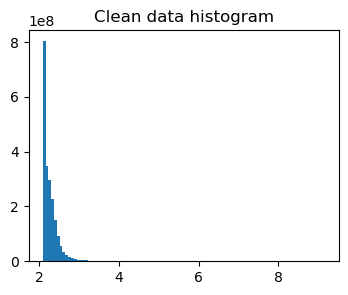

In [20]:
# plot data_clean histogram
plt.figure(figsize=(4, 3))
plt.hist(data_clean.flatten(), bins=100)
plt.title("Clean data histogram")
plt.show()

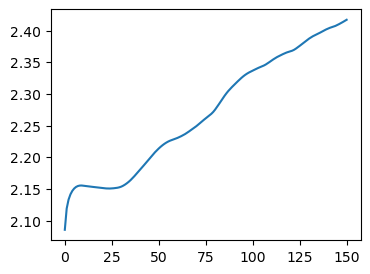

In [21]:
# plot data_clean average intensity over time
plt.figure(figsize=(4, 3))
plt.plot(np.mean(data_clean, axis=(1, 2, 3)))

**Remarks:**
- I'm looking for maxima in each slice along the z-axis, as this is the way I am computing maxima in the original dataset (tyx data).
- I need to detrend the data because the average fluorescence increases along time.

In [22]:
# # detrend data_snr100 along time axis
# data_clean_detrended = signal.detrend(data_clean, axis=0, type='linear')

In [23]:
# # plot detrended data_snr100 average intensity over time
# plt.figure(figsize=(4,3))
# plt.plot(np.mean(data_snr100_detrended, axis=(1,2,3)))

In [24]:
# # visualize detrended data using napari
# viewer = napari.Viewer()
# viewer.add_image(data_snr100,
#                  name='data snr100')
# viewer.add_image(data_snr100_detrended,
#                  name='data snr100 detrended')

In [26]:
def nonmaxima_suppression_tzyx(vol, neighborhood_radius=5, sigma=1.0, percentile=90):
    """
    vol is a noisy 4D array of shape (t, z, y, x)
    """
    # smooth data_
    smooth = gaussian_filter(vol, sigma=(sigma, 0, sigma, sigma))

    # compute smoot data's otus threshold
    otsu_t = threshold_otsu(smooth)

    # compute percentile of smooth data where otsu threshold is exceeded
    percentile_smooth = np.percentile(smooth[smooth > otsu_t], percentile)

    # threshold smooth data wrt 90th percentile
    thresholded_smooth = smooth > percentile_smooth

    # dilate smooth data
    dilated_smooth = grey_dilation(
        smooth, (neighborhood_radius, 0, neighborhood_radius, neighborhood_radius)
    )

    # get mask where smooth data is equal to dilated smooth data and
    # smooth data is above threshold
    argmaxima = np.logical_and(smooth == dilated_smooth, thresholded_smooth)

    # compute maxima's coordinates
    argwhere = np.argwhere(argmaxima)

    return argwhere, argmaxima, thresholded_smooth

In [27]:
def clean_nonmaxima_suppression_tzyx(vol, neighborhood_radius=5, threshold=0.5):
    """
    vol is a 4D array of shape (t, z, y, x)
    """
    # get mask where data is equal to dilated data and
    # data is above threshold
    argmaxima = np.logical_and(
        vol
        == grey_dilation(
            vol, (neighborhood_radius, 0, neighborhood_radius, neighborhood_radius)
        ),
        vol > threshold,
    )

    # compute maxima's coordinates
    argwhere = np.argwhere(argmaxima)

    return argwhere, argmaxima

In [28]:
# find local maxima in data_clean

t = data_clean.min() + 2 * data_clean.std()

argwhere, argmaxima = clean_nonmaxima_suppression_tzyx(
    vol=data_clean, neighborhood_radius=15, threshold=t
)

# find local maxima in detrended data_snr100
# argwhere_detrended, argmaxima_detrended, thresholded_smooth_detrended = nonmaxima_suppression_tzyx(
#     vol=data_snr100_detrended,
#     neighborhood_radius=5,
#     sigma=0.5,
#     percentile=99
#     )

In [29]:
argmaxima.shape

(151, 213, 205, 317)

In [30]:
len(argwhere)

3206

In [31]:
# visualize local maxima with napari
viewer = napari.Viewer()
viewer.add_image(data_clean, name="clean data")

# viewer.add_labels(argmaxima,
#                   name='local maxima',
#                   opacity=0.5,
#                   #visible=False
#                   )

# viewer.add_labels(argmaxima_detrended,
#                     name='local maxima detrended',
#                     opacity=0.5,
#                     #visible=False
#                     )

# viewer.add_labels(thresholded_smooth,
#                     name='thresholded smooth',
#                     opacity=0.5,
#                     #visible=False
#                     )
viewer.add_points(
    argwhere,
    name="local maxima coordinates",
    size=5,
    opacity=0.5,
    face_color="red",
    # visible=False
)

<Points layer 'local maxima coordinates' at 0x25751758340>

#### Interpolate video to match original dataset's sampling time

This is done via the method `video_spline_interpolation` of the `SparkDataset` class

### Run UNet on simulated data

#### Load UNet model